In [1]:
import random
import numpy as np
import seaborn as sns
import math
import os
import matplotlib.pyplot as plt
import traceback
import pandas as pd
from scipy.stats import multivariate_normal
from scipy.stats import norm
from select_sensor import SelectSensor
from sensor import Sensor

In [2]:
select_sensor = SelectSensor('config.json')

select_sensor.read_init_sensor('sensor.txt')
select_sensor.read_mean_std('mean_std.txt')
select_sensor.compute_multivariant_gaussian()
print('error ', select_sensor.test_error())
select_sensor.print()

Computed covariance!
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
error  0.15512
(0, 0)  8
(0, 1)  8
(0, 2)  8
(0, 3)  8
(0, 4)  7
(0, 5)  6
(0, 6)  1
(0, 7)  2
(0, 8)  0
(0, 9)  0
(0, 10)  2
(0, 11)  2
(0, 12)  2
(0, 13)  1
(0, 14)  3
(0, 15)  0
(0, 16)  1
(0, 17)  1
(0, 18)  0
(0, 19)  3
(0, 20)  3
(0, 21)  5
(0, 22)  3
(0, 23)  5
(0, 24)  3
(0, 25)  0
(0, 26)  0
(0, 27)  1
(0, 28)  0
(0, 29)  2
(0, 30)  0
(0, 31)  0
(0, 32)  0
(0, 33)  2
(0, 34)  0
(0, 35)  1
(0, 36)  4
(0, 37)  6
(0, 38)  9
(0, 39)  8
(0, 40)  7
(0, 41)  4
(0, 42)  4
(0, 43)  6
(0, 44)  3
(0, 45)  2
(0, 46)  0
(0, 47)  0
(0, 48)  0
(0, 49)  0
(1, 0)  7
(1, 1)  8
(1, 2)  7
(1, 3)  9
(1, 4)  9
(1, 5)  3
(1, 6)  4
(1, 7)  0
(1, 8)  0
(1, 9)  0
(1, 10)  0
(1, 11)  0
(1, 12)  0
(1, 13)  1
(1, 14)  0
(1, 15)  0
(1, 16)  0
(1, 17)  0
(1, 18)  0
(1, 19)  0
(1, 20)  3
(1, 21)  4
(1, 22)  3
(1, 23)  4
(1, 24)  2
(1, 25)  1
(1, 26) 

(17, 18)  0
(17, 19)  2
(17, 20)  0
(17, 21)  0
(17, 22)  0
(17, 23)  1
(17, 24)  0
(17, 25)  1
(17, 26)  0
(17, 27)  2
(17, 28)  5
(17, 29)  0
(17, 30)  0
(17, 31)  0
(17, 32)  0
(17, 33)  0
(17, 34)  2
(17, 35)  5
(17, 36)  5
(17, 37)  1
(17, 38)  1
(17, 39)  1
(17, 40)  0
(17, 41)  0
(17, 42)  0
(17, 43)  1
(17, 44)  0
(17, 45)  0
(17, 46)  0
(17, 47)  0
(17, 48)  2
(17, 49)  4
(18, 0)  3
(18, 1)  3
(18, 2)  7
(18, 3)  4
(18, 4)  5
(18, 5)  6
(18, 6)  6
(18, 7)  2
(18, 8)  2
(18, 9)  2
(18, 10)  0
(18, 11)  2
(18, 12)  0
(18, 13)  0
(18, 14)  0
(18, 15)  1
(18, 16)  2
(18, 17)  3
(18, 18)  2
(18, 19)  0
(18, 20)  0
(18, 21)  0
(18, 22)  1
(18, 23)  2
(18, 24)  0
(18, 25)  0
(18, 26)  3
(18, 27)  1
(18, 28)  3
(18, 29)  0
(18, 30)  0
(18, 31)  0
(18, 32)  1
(18, 33)  0
(18, 34)  3
(18, 35)  6
(18, 36)  6
(18, 37)  6
(18, 38)  2
(18, 39)  1
(18, 40)  0
(18, 41)  2
(18, 42)  2
(18, 43)  1
(18, 44)  1
(18, 45)  1
(18, 46)  0
(18, 47)  2
(18, 48)  2
(18, 49)  3
(19, 0)  2
(19, 1)  7
(19,

(45, 44)  0
(45, 45)  0
(45, 46)  0
(45, 47)  0
(45, 48)  0
(45, 49)  2
(46, 0)  1
(46, 1)  0
(46, 2)  0
(46, 3)  0
(46, 4)  0
(46, 5)  0
(46, 6)  0
(46, 7)  0
(46, 8)  0
(46, 9)  0
(46, 10)  0
(46, 11)  1
(46, 12)  0
(46, 13)  3
(46, 14)  2
(46, 15)  5
(46, 16)  8
(46, 17)  5
(46, 18)  5
(46, 19)  5
(46, 20)  5
(46, 21)  6
(46, 22)  7
(46, 23)  3
(46, 24)  1
(46, 25)  2
(46, 26)  0
(46, 27)  0
(46, 28)  0
(46, 29)  0
(46, 30)  1
(46, 31)  0
(46, 32)  0
(46, 33)  0
(46, 34)  0
(46, 35)  0
(46, 36)  0
(46, 37)  0
(46, 38)  0
(46, 39)  0
(46, 40)  0
(46, 41)  0
(46, 42)  0
(46, 43)  0
(46, 44)  0
(46, 45)  0
(46, 46)  0
(46, 47)  0
(46, 48)  1
(46, 49)  4
(47, 0)  0
(47, 1)  0
(47, 2)  0
(47, 3)  1
(47, 4)  0
(47, 5)  0
(47, 6)  0
(47, 7)  0
(47, 8)  0
(47, 9)  0
(47, 10)  0
(47, 11)  0
(47, 12)  0
(47, 13)  2
(47, 14)  7
(47, 15)  4
(47, 16)  5
(47, 17)  6
(47, 18)  6
(47, 19)  9
(47, 20)  7
(47, 21)  4
(47, 22)  7
(47, 23)  3
(47, 24)  6
(47, 25)  5
(47, 26)  0
(47, 27)  2
(47, 28)  0


In [ ]:
x = np.linspace(-10, 10, 100)
y = multivariate_normal.pdf(x, mean=0, cov=1); y

plt.plot(x, y)
plt.show()

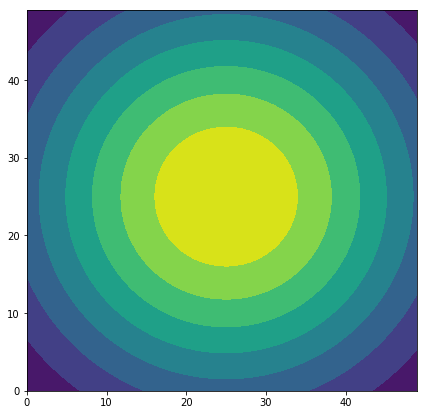

In [44]:
x, y = np.mgrid[0:50:1, 0:50:1]
pos = np.zeros(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal(mean_vec.T, [[400, 0], [0, 400]])
plt.figure(figsize=(7,7))
plt.contourf(x, y, rv.pdf(pos))
plt.show()

In [8]:
sensors = {}
with open('sensor.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        line = line.split(' ')
        x, y, std = int(line[0]), int(line[1]), float(line[2])
        sensors[(x, y)] = Sensor(x, y, std)

In [25]:
grid = np.zeros((50, 50))
for sensor in sensors:
    x, y = sensor[0], sensor[1]
    grid[x][y] = 1

In [49]:
with open('higherror.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        line = line.replace('(', '')
        line = line.replace(', ', ' ')
        line = line.replace(') ', '')
        line = line.strip()
        line = line.split(' ')
        x, y, e = int(line[0]), int(line[1]), float(line[2])
        if e > 0:
            if grid[x][y] > 0.99:
                grid[x][y] = 0.5
            else:
                grid[x][y] = -e/10

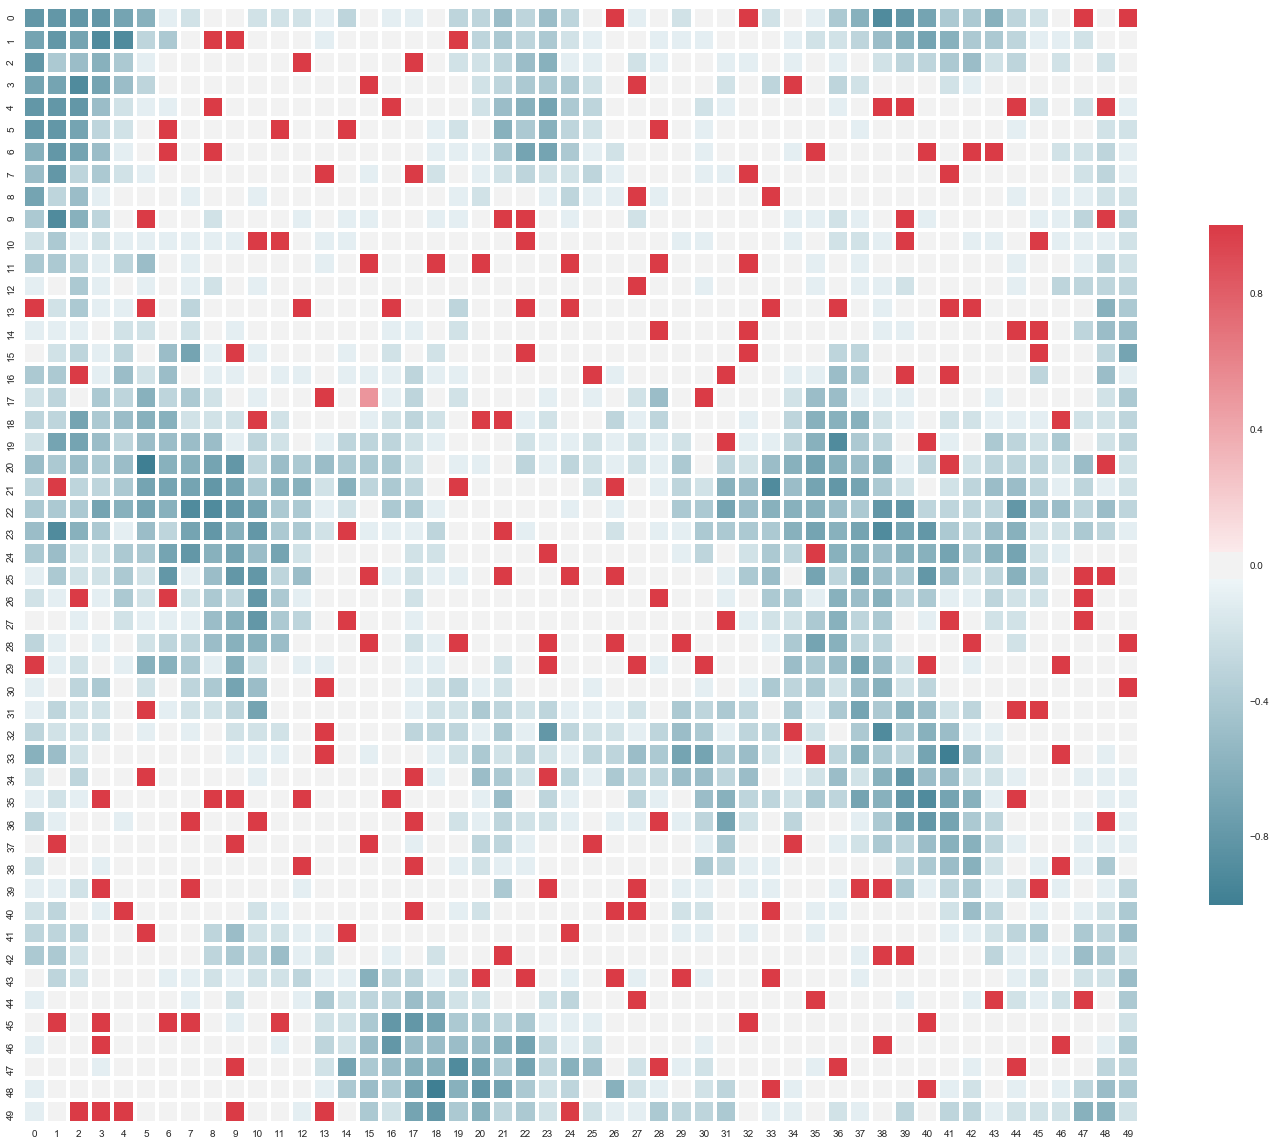

In [50]:
sns.set(style="white")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(grid, cmap=cmap, vmax=1, center=0,
            square=True, linewidth=3, cbar_kws={"shrink": .5})

plt.show()

In [55]:
a = [2,3,1]

In [57]:
a.sort()

In [58]:
a

[1, 2, 3]

In [59]:
mean_vec = [0, 1, 2, 3, 4, 5, 6, 7, 8 ,9]

In [64]:
indexes = [2, 5, 7, 9]

In [65]:
mean_vec2 = []
for index in indexes:
    mean_vec2.append(index)

In [66]:
mean_vec2

[2, 5, 7, 9]

In [71]:
selectsensor = SelectSensor('config.json')

selectsensor.read_init_sensor('sensor.txt')
selectsensor.read_mean_std('mean_std.txt')
selectsensor.compute_multivariant_gaussian()

Computed covariance!


In [84]:
selectsensor.covariance

array([[ 174.28426299,  -82.21460331,  151.10581654, ...,  -28.04220525,
         -71.72907023,  127.34279318],
       [ -82.21460331,  150.80652645,  -69.2477499 , ...,   62.86713998,
          -0.94724978,  -59.00279209],
       [ 151.10581654,  -69.2477499 ,  155.16841428, ...,  -11.13304388,
         -75.52235783,  118.51516831],
       ..., 
       [ -28.04220525,   62.86713998,  -11.13304388, ...,  148.14417508,
         -66.8726986 ,   -7.35660933],
       [ -71.72907023,   -0.94724978,  -75.52235783, ...,  -66.8726986 ,
         151.11987588,  -61.19361483],
       [ 127.34279318,  -59.00279209,  118.51516831, ...,   -7.35660933,
         -61.19361483,  156.27029421]])

In [3]:
selectsensor = SelectSensor('config.json')

selectsensor.read_init_sensor('sensor.txt')
selectsensor.read_mean_std('mean_std.txt')
selectsensor.compute_multivariant_gaussian()

selectsensor.select_subset_random(0.75)
print('error ', selectsensor.test_error())
selectsensor.print()
print('\n*****************b**********************\n')
selectsensor.select_subset_random(0.5)
print('error ', selectsensor.test_error())
selectsensor.print()

Computed covariance!
0
5
10
15
20
25
30
35
40
45
error  0.22688
(0, 0)  3
(0, 1)  9
(0, 2)  4
(0, 3)  6
(0, 4)  6
(0, 5)  3
(0, 6)  2
(0, 7)  0
(0, 8)  0
(0, 9)  0
(0, 10)  1
(0, 11)  2
(0, 12)  4
(0, 13)  4
(0, 14)  3
(0, 15)  4
(0, 16)  5
(0, 17)  4
(0, 18)  7
(0, 19)  5
(0, 20)  6
(0, 21)  8
(0, 22)  5
(0, 23)  7
(0, 24)  7
(0, 25)  8
(0, 26)  7
(0, 27)  4
(0, 28)  6
(0, 29)  3
(0, 30)  2
(0, 31)  0
(0, 32)  0
(0, 33)  0
(0, 34)  0
(0, 35)  1
(0, 36)  6
(0, 37)  7
(0, 38)  8
(0, 39)  4
(0, 40)  5
(0, 41)  5
(0, 42)  7
(0, 43)  4
(0, 44)  1
(0, 45)  0
(0, 46)  0
(0, 47)  0
(0, 48)  0
(0, 49)  0
(1, 0)  7
(1, 1)  10
(1, 2)  9
(1, 3)  6
(1, 4)  7
(1, 5)  3
(1, 6)  1
(1, 7)  0
(1, 8)  0
(1, 9)  0
(1, 10)  0
(1, 11)  4
(1, 12)  8
(1, 13)  2
(1, 14)  0
(1, 15)  1
(1, 16)  1
(1, 17)  1
(1, 18)  2
(1, 19)  5
(1, 20)  5
(1, 21)  7
(1, 22)  6
(1, 23)  7
(1, 24)  8
(1, 25)  6
(1, 26)  4
(1, 27)  5
(1, 28)  2
(1, 29)  7
(1, 30)  2
(1, 31)  0
(1, 32)  4
(1, 33)  0
(1, 34)  1
(1, 35)  0
(1, 36)  

(37, 12)  0
(37, 13)  0
(37, 14)  0
(37, 15)  0
(37, 16)  0
(37, 17)  0
(37, 18)  1
(37, 19)  2
(37, 20)  3
(37, 21)  0
(37, 22)  2
(37, 23)  0
(37, 24)  0
(37, 25)  0
(37, 26)  0
(37, 27)  0
(37, 28)  1
(37, 29)  0
(37, 30)  5
(37, 31)  2
(37, 32)  3
(37, 33)  0
(37, 34)  0
(37, 35)  0
(37, 36)  0
(37, 37)  3
(37, 38)  4
(37, 39)  4
(37, 40)  8
(37, 41)  7
(37, 42)  3
(37, 43)  3
(37, 44)  1
(37, 45)  1
(37, 46)  1
(37, 47)  0
(37, 48)  0
(37, 49)  0
(38, 0)  3
(38, 1)  4
(38, 2)  2
(38, 3)  2
(38, 4)  0
(38, 5)  0
(38, 6)  1
(38, 7)  0
(38, 8)  0
(38, 9)  0
(38, 10)  0
(38, 11)  0
(38, 12)  0
(38, 13)  1
(38, 14)  0
(38, 15)  0
(38, 16)  0
(38, 17)  0
(38, 18)  0
(38, 19)  1
(38, 20)  3
(38, 21)  2
(38, 22)  0
(38, 23)  2
(38, 24)  0
(38, 25)  1
(38, 26)  0
(38, 27)  0
(38, 28)  3
(38, 29)  2
(38, 30)  2
(38, 31)  4
(38, 32)  0
(38, 33)  0
(38, 34)  0
(38, 35)  0
(38, 36)  2
(38, 37)  0
(38, 38)  4
(38, 39)  4
(38, 40)  6
(38, 41)  4
(38, 42)  5
(38, 43)  1
(38, 44)  1
(38, 45)  1
(3

(9, 32)  1
(9, 33)  2
(9, 34)  2
(9, 35)  3
(9, 36)  7
(9, 37)  3
(9, 38)  5
(9, 39)  4
(9, 40)  3
(9, 41)  2
(9, 42)  2
(9, 43)  2
(9, 44)  1
(9, 45)  2
(9, 46)  4
(9, 47)  7
(9, 48)  5
(9, 49)  4
(10, 0)  8
(10, 1)  13
(10, 2)  7
(10, 3)  8
(10, 4)  7
(10, 5)  8
(10, 6)  4
(10, 7)  3
(10, 8)  3
(10, 9)  1
(10, 10)  0
(10, 11)  0
(10, 12)  0
(10, 13)  0
(10, 14)  1
(10, 15)  3
(10, 16)  5
(10, 17)  3
(10, 18)  1
(10, 19)  2
(10, 20)  4
(10, 21)  0
(10, 22)  0
(10, 23)  0
(10, 24)  3
(10, 25)  1
(10, 26)  0
(10, 27)  2
(10, 28)  1
(10, 29)  2
(10, 30)  3
(10, 31)  4
(10, 32)  3
(10, 33)  4
(10, 34)  6
(10, 35)  8
(10, 36)  5
(10, 37)  5
(10, 38)  3
(10, 39)  6
(10, 40)  4
(10, 41)  5
(10, 42)  2
(10, 43)  5
(10, 44)  3
(10, 45)  0
(10, 46)  3
(10, 47)  5
(10, 48)  11
(10, 49)  6
(11, 0)  3
(11, 1)  9
(11, 2)  8
(11, 3)  8
(11, 4)  6
(11, 5)  7
(11, 6)  6
(11, 7)  8
(11, 8)  5
(11, 9)  1
(11, 10)  0
(11, 11)  0
(11, 12)  0
(11, 13)  1
(11, 14)  3
(11, 15)  2
(11, 16)  0
(11, 17)  1
(11,

(46, 22)  8
(46, 23)  10
(46, 24)  4
(46, 25)  1
(46, 26)  4
(46, 27)  0
(46, 28)  2
(46, 29)  2
(46, 30)  5
(46, 31)  1
(46, 32)  1
(46, 33)  1
(46, 34)  0
(46, 35)  1
(46, 36)  8
(46, 37)  5
(46, 38)  7
(46, 39)  3
(46, 40)  7
(46, 41)  8
(46, 42)  4
(46, 43)  5
(46, 44)  2
(46, 45)  1
(46, 46)  0
(46, 47)  2
(46, 48)  4
(46, 49)  7
(47, 0)  1
(47, 1)  2
(47, 2)  1
(47, 3)  1
(47, 4)  2
(47, 5)  2
(47, 6)  3
(47, 7)  5
(47, 8)  1
(47, 9)  0
(47, 10)  0
(47, 11)  1
(47, 12)  0
(47, 13)  3
(47, 14)  7
(47, 15)  9
(47, 16)  14
(47, 17)  15
(47, 18)  9
(47, 19)  9
(47, 20)  11
(47, 21)  9
(47, 22)  12
(47, 23)  7
(47, 24)  5
(47, 25)  4
(47, 26)  1
(47, 27)  3
(47, 28)  0
(47, 29)  1
(47, 30)  4
(47, 31)  0
(47, 32)  1
(47, 33)  4
(47, 34)  1
(47, 35)  3
(47, 36)  5
(47, 37)  4
(47, 38)  6
(47, 39)  6
(47, 40)  7
(47, 41)  9
(47, 42)  2
(47, 43)  3
(47, 44)  4
(47, 45)  2
(47, 46)  1
(47, 47)  1
(47, 48)  11
(47, 49)  7
(48, 0)  0
(48, 1)  3
(48, 2)  2
(48, 3)  1
(48, 4)  0
(48, 5)  2
(4

array([[ 174.28426299,  -82.21460331,  151.10581654, ...,  -28.04220525,
         -71.72907023,  127.34279318],
       [ -82.21460331,  150.80652645,  -69.2477499 , ...,   62.86713998,
          -0.94724978,  -59.00279209],
       [ 151.10581654,  -69.2477499 ,  155.16841428, ...,  -11.13304388,
         -75.52235783,  118.51516831],
       ..., 
       [ -28.04220525,   62.86713998,  -11.13304388, ...,  148.14417508,
         -66.8726986 ,   -7.35660933],
       [ -71.72907023,   -0.94724978,  -75.52235783, ...,  -66.8726986 ,
         151.11987588,  -61.19361483],
       [ 127.34279318,  -59.00279209,  118.51516831, ...,   -7.35660933,
         -61.19361483,  156.27029421]])

In [67]:
mat = [[2, 1, -1],
       [0, -1, 2],
       [1, 0, 3]]

np.linalg.inv(mat)

array([[ 0.6,  0.6, -0.2],
       [-0.4, -1.4,  0.8],
       [-0.2, -0.2,  0.4]])

In [81]:
mean_vec1 = np.array([1, 2, 3])
mean_vec2 = np.array([[1, -1, 1],
                      [2, -2, 2],
                      [3, -3, 3]])

In [85]:
np.dot(mean_vec1.T, mean_vec2)

array([ 14, -14,  14])

In [74]:
mean_vec1

array([[1],
       [2],
       [3]])

In [88]:
np.dot(np.linalg.inv(selectsensor.covariance), selectsensor.covariance)

array([[  1.00000000e+00,  -1.63619118e-14,   3.57561203e-14, ...,
          4.65183447e-14,  -8.75410855e-14,   4.47697435e-14],
       [  7.81180676e-14,   1.00000000e+00,   5.80230308e-14, ...,
         -6.24500451e-16,  -5.99104100e-14,   6.09373663e-14],
       [  1.86517468e-14,  -4.71844785e-14,   1.00000000e+00, ...,
         -4.35207426e-14,   2.62290190e-14,  -1.15393806e-14],
       ..., 
       [ -3.55271368e-15,   0.00000000e+00,  -5.32907052e-15, ...,
          1.00000000e+00,   1.24344979e-14,  -4.44089210e-15],
       [ -3.55271368e-15,  -2.66453526e-15,   0.00000000e+00, ...,
         -7.10542736e-15,   1.00000000e+00,  -3.55271368e-15],
       [  1.77635684e-14,  -2.66453526e-15,   1.42108547e-14, ...,
          1.11022302e-16,  -1.77635684e-15,   1.00000000e+00]])

In [89]:
np.linalg.inv(selectsensor.covariance)

array([[  2.37907261e-01,   4.24895912e-04,  -2.55943402e-03, ...,
          2.24180793e-03,   6.07723868e-05,  -4.45965860e-05],
       [  4.24895912e-04,   2.15335464e-01,   3.03236372e-04, ...,
          5.57477131e-04,  -1.17689445e-04,  -5.70241142e-06],
       [ -2.55943402e-03,   3.03236372e-04,   1.90361167e-01, ...,
          3.33753140e-03,  -1.92839933e-04,  -3.04252893e-04],
       ..., 
       [  2.24180793e-03,   5.57477131e-04,   3.33753140e-03, ...,
          1.46332837e-01,  -4.20419788e-04,   3.08688455e-04],
       [  6.07723868e-05,  -1.17689445e-04,  -1.92839933e-04, ...,
         -4.20419788e-04,   2.33325169e-01,  -1.44132223e-04],
       [ -4.45965860e-05,  -5.70241142e-06,  -3.04252893e-04, ...,
          3.08688455e-04,  -1.44132223e-04,   1.74383317e-01]])

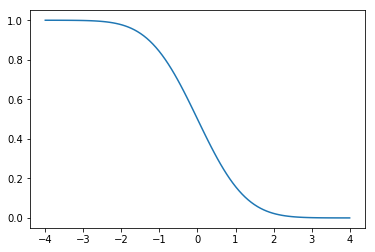

In [117]:
x = np.linspace(-4, 4, 100)
y = norm.sf(x)
plt.plot(x, y)
plt.show()

In [3]:
selectsensor = SelectSensor('config.json')

selectsensor.read_init_sensor('data/sensor.txt')
selectsensor.read_mean_std('data/mean_std.txt')
selectsensor.compute_multivariant_gaussian('data/artificial_samples.csv', 'data/mean_vector.txt')
selectsensor.no_selection()
print('error ', selectsensor.test_error())
selectsensor.print()

Computed covariance!
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
error  0.029333333333333333
(0, 0)  0
(0, 1)  0
(0, 2)  0
(0, 3)  0
(0, 4)  0
(0, 5)  0
(0, 6)  0
(0, 7)  0
(0, 8)  0
(0, 9)  1
(0, 10)  3
(0, 11)  1
(0, 12)  0
(0, 13)  3
(0, 14)  0
(1, 0)  0
(1, 1)  0
(1, 2)  0
(1, 3)  0
(1, 4)  1
(1, 5)  0
(1, 6)  1
(1, 7)  0
(1, 8)  0
(1, 9)  0
(1, 10)  0
(1, 11)  2
(1, 12)  1
(1, 13)  2
(1, 14)  4
(2, 0)  0
(2, 1)  0
(2, 2)  0
(2, 3)  0
(2, 4)  0
(2, 5)  0
(2, 6)  0
(2, 7)  0
(2, 8)  0
(2, 9)  0
(2, 10)  1
(2, 11)  3
(2, 12)  0
(2, 13)  0
(2, 14)  0
(3, 0)  0
(3, 1)  0
(3, 2)  0
(3, 3)  0
(3, 4)  0
(3, 5)  0
(3, 6)  0
(3, 7)  0
(3, 8)  1
(3, 9)  1
(3, 10)  1
(3, 11)  0
(3, 12)  1
(3, 13)  0
(3, 14)  0
(4, 0)  0
(4, 1)  0
(4, 2)  0
(4, 3)  0
(4, 4)  0
(4, 5)  1
(4, 6)  2
(4, 7)  0
(4, 8)  1
(4, 9)  0
(4, 10)  0
(4, 11)  0
(4, 12)  0
(4, 13)  0
(4, 14)  0
(5, 0)  0
(5, 1)  0
(5, 2)  0
(5, 3)  0
(5, 4)  0
(5, 5)  0
(5, 6)  0
(5, 7)  0
(5, 8)  0
(5, 9)  2
(5, 10)  0
(5, 11)  0
(5, 12)  0
(5, 13) 

In [4]:
mylist = [3, 4, 2, 1]

In [7]:
type(mylist.sort())

NoneType